# GlyphGAN Implementation

This is a naive implementation of the GlyphGAN paper.

## Configuration

In [58]:
# Basic Torch
import torch
import torch.nn as nn
from torch.nn import init
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import grad as torch_grad

# Torch Vision and Images
import torchvision
import torchvision.transforms as T
from torchvision.utils import make_grid
import PIL
from imageio import imread
import imageio

# Data Management
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as datasets

import numpy as np

# matplot
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Other
import time

# Other Constants

USE_GPU = True

dtype = torch.FloatTensor

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
    dtype = torch.cuda.FloatTensor
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cpu


## Helper Methods
These helper methods were taken from the CS231N class assignments.

In [59]:
def show_images(images):
    images = np.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return 

def preprocess(img, size=512):
    transform = T.Compose([
        T.Resize(size),
        T.ToTensor(),
        T.Normalize(mean=SQUEEZENET_MEAN.tolist(), std=SQUEEZENET_STD.tolist()),
        T.Lambda(lambda x: x[None]),
    ])
    return transform(img)

def deprocess(img):
    transform = T.Compose([
        T.Lambda(lambda x: x[0]),
        T.Normalize(mean=[0, 0, 0], std=[1.0 / s for s in SQUEEZENET_STD.tolist()]),
        T.Normalize(mean=[-m for m in SQUEEZENET_MEAN.tolist()], std=[1, 1, 1]),
        T.Lambda(rescale),
        T.ToPILImage(),
    ])
    return transform(img)

def rescale(x):
    low, high = x.min(), x.max()
    x_rescaled = (x - low) / (high - low)
    return x_rescaled

def rel_error(x,y):
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

def features_from_img(imgpath, imgsize):
    img = preprocess(PIL.Image.open(imgpath), size=imgsize)
    img_var = img.type(dtype)
    return extract_features(img_var, cnn), img_var

# Older versions of scipy.misc.imresize yield different results
# from newer versions, so we check to make sure scipy is up to date.
def check_scipy():
    import scipy
    vnum = int(scipy.__version__.split('.')[1])
    major_vnum = int(scipy.__version__.split('.')[0])
    
    assert vnum >= 16 or major_vnum >= 1, "You must install SciPy >= 0.16.0 to complete this notebook."

check_scipy()

# Taken from Assignment 3 of CS231N
def extract_features(x, cnn):
    """
    Use the CNN to extract features from the input image x.
    
    Inputs:
    - x: A PyTorch Tensor of shape (N, C, H, W) holding a minibatch of images that
      will be fed to the CNN.
    - cnn: A PyTorch model that we will use to extract features.
    
    Returns:
    - features: A list of feature for the input images x extracted using the cnn model.
      features[i] is a PyTorch Tensor of shape (N, C_i, H_i, W_i); recall that features
      from different layers of the network may have different numbers of channels (C_i) and
      spatial dimensions (H_i, W_i).
    """
    features = []
    prev_feat = x
    for i, module in enumerate(cnn._modules.values()):
        next_feat = module(prev_feat)
        features.append(next_feat)
        prev_feat = next_feat
    return features

class Flatten(nn.Module):
    def forward(self, x):
        N, C, H, W = x.size() # read in N, C, H, W
        return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image
    
class Unflatten(nn.Module):
    """
    An Unflatten module receives an input of shape (N, C*H*W) and reshapes it
    to produce an output of shape (N, C, H, W).
    """
    def __init__(self, N=-1, C=128, H=7, W=7):
        super(Unflatten, self).__init__()
        self.N = N
        self.C = C
        self.H = H
        self.W = W
    def forward(self, x):
        return x.view(self.N, self.C, self.H, self.W)

def initialize_weights(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.ConvTranspose2d):
        init.xavier_uniform_(m.weight.data)
        
def get_optimizer(model):
    """
    Construct and return an Adam optimizer for the model with learning rate 1e-3,
    beta1=0.5, and beta2=0.999.
    
    Input:
    - model: A PyTorch model that we want to optimize.
    
    Returns:
    - An Adam optimizer for the model with the desired hyperparameters.
    """
    #torch.optim.Adam(params, lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
    optimizer = optim.Adam(model.parameters(), lr=1e-3, betas=(0.5, 0.999))
    return optimizer

def sample_noise(batch_size, dim):
    """
    Generate a PyTorch Tensor of uniform random noise.

    Input:
    - batch_size: Integer giving the batch size of noise to generate.
    - dim: Integer giving the dimension of noise to generate.
    
    Output:
    - A PyTorch Tensor of shape (batch_size, dim) containing uniform
      random noise in the range (-1, 1).
    """
    return torch.rand((batch_size, dim)) * 2 - 1

## Prepare our Training/Validation Data

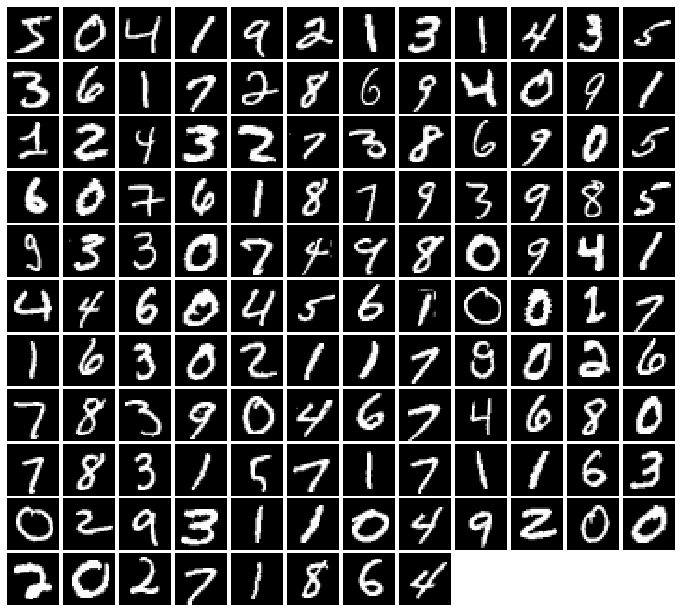

In [60]:
class ChunkSampler(sampler.Sampler):
    """Samples elements sequentially from some offset. 
    Arguments:
        num_samples: # of desired datapoints
        start: offset where we should start selecting from
    """
    def __init__(self, num_samples, start=0):
        self.num_samples = num_samples
        self.start = start

    def __iter__(self):
        return iter(range(self.start, self.start + self.num_samples))

    def __len__(self):
        return self.num_samples

# We aim to have a training size a multiple of of both our batch size and critic_iterations (usually 5)
NUM_TRAIN = 49920
NUM_VAL = 5120

NOISE_DIM = 96
LOADER_BATCH_SIZE = 128

mnist_train = datasets.MNIST('./datasets/MNIST_data', train=True, download=True, transform=T.ToTensor())
loader_train = DataLoader(mnist_train, batch_size=LOADER_BATCH_SIZE, sampler=ChunkSampler(NUM_TRAIN, 0))

mnist_val = datasets.MNIST('./datasets/MNIST_data', train=True, download=True, transform=T.ToTensor())
loader_val = DataLoader(mnist_val, batch_size=LOADER_BATCH_SIZE, sampler=ChunkSampler(NUM_VAL, NUM_TRAIN))

imgs = loader_train.__iter__().next()[0].view(LOADER_BATCH_SIZE, 784).numpy().squeeze()
show_images(imgs)

In [48]:
def build_glyph_gan_discriminator(batch_size, class_count):
    """
    PyTorch model implementing the GlyphGAN discriminator.
    """
    return nn.Sequential(
        # The GlyphGAN paper used images (3x64x64. We have 1x28x28 from the MNIST data set)
        Unflatten(batch_size, 1, 28, 28),
        
        # 4 Conv Layers, stride 2 (28x28 -> 24x24)
        nn.Conv2d(1, 32, 5),
        nn.LeakyReLU(),
        
        # (24x24 -> 11x11)
        nn.Conv2d(32, 64, 3, stride=2),
        nn.LeakyReLU(),
        
        # (24x24 -> 5x5)
        nn.Conv2d(64, 128, 3, stride=2),
        nn.LeakyReLU(),
        
        # (2x2)
        nn.Conv2d(128, 256, 3, stride=2),
        nn.LeakyReLU(),
        
        # Final Affine Steps
        Flatten(),
        nn.Linear(1024, 1024),
        nn.LeakyReLU(),
        nn.Linear(1024, class_count)
    )

data = next(enumerate(loader_train))[-1][0].type(dtype)
discriminator = build_glyph_gan_discriminator(LOADER_BATCH_SIZE, 10).type(dtype)
out = discriminator(data)
print(out.size())

torch.Size([128, 10])


In [49]:
def train(model, optimizer, training_loader, validation_loader, batch_size=128, num_epochs=10, show_every=250):
    for epoch in range(num_epochs):
        for t, (x, y) in enumerate(training_loader):
            model.train()
            
            optimizer.zero_grad()
            
            x = x.type(dtype)
            y = y.type(torch.cuda.LongTensor)
            
            # Forward pass
            scores = model(x).type(dtype)
            loss = F.cross_entropy(scores, y)
            
            # Backward pass
            loss.backward()
            
            optimizer.step()
            
            if (t % show_every == 0):
                print('Epoch %d, Iteration %d, loss = %.4f' % (epoch, t, loss.item()))
                check_accuracy(validation_loader, model)

In [50]:
SHOULD_TEST_CLASSIFIER = False

def check_accuracy(loader, model):
    if loader.dataset.train:
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')   
    num_correct = 0
    num_samples = 0
    model.eval()
    with torch.no_grad():
        for x, y in loader:
            x = x.type(dtype)
            y = y.to(device=device, dtype=torch.long)
            
            scores = model(x).type(dtype)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))

if SHOULD_TEST_CLASSIFIER:
    model = build_glyph_gan_discriminator(LOADER_BATCH_SIZE, 10).type(dtype)
    optimizer = get_optimizer(model)
    train(model, optimizer, loader_train, loader_val)

## Generator

We're comfortable that our generator is actually a pretty decent classifier! Now, let's put things together. We'll start by putting the DCGAN generator in front of it, and see what happens.

In [7]:
def build_generator(batch_size, noise_dim):
    """
    PyTorch model implementing the DCGAN generator.
    """
    return nn.Sequential(
        nn.Linear(noise_dim, 1024),
        nn.ReLU(),
        nn.BatchNorm1d(1024),
        nn.Linear(1024, 7 * 7 * 128),
        nn.ReLU(),
        nn.BatchNorm1d(7 * 7 * 128),
        Unflatten(batch_size, 128, 7, 7),
        nn.ConvTranspose2d(128, 64, 4, 2, 1),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.ConvTranspose2d(64, 1, 4, 2, 1),
        nn.Tanh(),
        nn.Flatten(1)
    )

test_g_gan = build_generator(LOADER_BATCH_SIZE, NOISE_DIM).type(dtype)
test_g_gan.apply(initialize_weights)

fake_seed = torch.randn(LOADER_BATCH_SIZE, NOISE_DIM).type(dtype)
fake_images = test_g_gan.forward(fake_seed)
fake_images.size()

torch.Size([128, 784])

## Loss!

In [8]:
def bce_loss(input, target):
    """
    Numerically stable version of the binary cross-entropy loss function.

    As per https://github.com/pytorch/pytorch/issues/751
    See the TensorFlow docs for a derivation of this formula:
    https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits

    Inputs:
    - input: PyTorch Tensor of shape (N, ) giving scores.
    - target: PyTorch Tensor of shape (N,) containing 0 and 1 giving targets.

    Returns:
    - A PyTorch Tensor containing the mean BCE loss over the minibatch of input data.
    """
    neg_abs = - input.abs()
    loss = input.clamp(min=0) - input * target + (1 + neg_abs.exp()).log()
    return loss.mean()

def discriminator_loss(logits_real, logits_fake):
    """
    Computes the discriminator loss described above.
    
    Inputs:
    - logits_real: PyTorch Tensor of shape (N,) giving scores for the real data.
    - logits_fake: PyTorch Tensor of shape (N,) giving scores for the fake data.
    
    Returns:
    - loss: PyTorch Tensor containing (scalar) the loss for the discriminator.
    """
    size = logits_real.size()
    true_labels = torch.ones(size).type(dtype)
    loss = bce_loss(logits_real, true_labels) + bce_loss(logits_fake, true_labels - 1)
    return loss

def generator_loss(logits_fake):
    """
    Computes the generator loss described above.

    Inputs:
    - logits_fake: PyTorch Tensor of shape (N,) giving scores for the fake data.
    
    Returns:
    - loss: PyTorch Tensor containing the (scalar) loss for the generator.
    """
    size = logits_fake.size()
    true_labels = torch.ones(size).type(dtype)
    loss = bce_loss(logits_fake, true_labels)
    return loss

In [9]:
def run_a_gan(D, G, D_solver, G_solver, discriminator_loss, generator_loss, show_every=250, batch_size=128, noise_size=96, num_epochs=10):
    """
    Train a GAN!
    
    Inputs:
    - D, G: PyTorch models for the discriminator and generator
    - D_solver, G_solver: torch.optim Optimizers to use for training the
      discriminator and generator.
    - discriminator_loss, generator_loss: Functions to use for computing the generator and
      discriminator loss, respectively.
    - show_every: Show samples after every show_every iterations.
    - batch_size: Batch size to use for training.
    - noise_size: Dimension of the noise to use as input to the generator.
    - num_epochs: Number of epochs over the training dataset to use for training.
    """
    iter_count = 0
    for epoch in range(num_epochs):
        for x, _ in loader_train:
            if len(x) != batch_size:
                continue
            D_solver.zero_grad()
            real_data = x.type(dtype)
            logits_real = D(2* (real_data - 0.5)).type(dtype)

            g_fake_seed = sample_noise(batch_size, noise_size).type(dtype)
            fake_images = G(g_fake_seed).detach()
            logits_fake = D(fake_images.view(batch_size, 1, 28, 28))

            d_total_error = discriminator_loss(logits_real, logits_fake)
            d_total_error.backward()        
            D_solver.step()

            G_solver.zero_grad()
            g_fake_seed = sample_noise(batch_size, noise_size).type(dtype)
            fake_images = G(g_fake_seed)

            gen_logits_fake = D(fake_images.view(batch_size, 1, 28, 28))
            g_error = generator_loss(gen_logits_fake)
            g_error.backward()
            G_solver.step()

            if (iter_count % show_every == 0):
                print('Iter: {}, D: {:.4}, G:{:.4}'.format(iter_count,d_total_error.item(),g_error.item()))
                imgs_numpy = fake_images.data.cpu().numpy()
                show_images(imgs_numpy[0:16])
                plt.show()
                print()
            iter_count += 1

Iter: 0, D: 1.378, G:0.6406


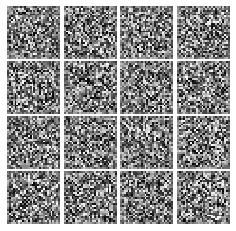


Iter: 250, D: 1.257, G:1.813


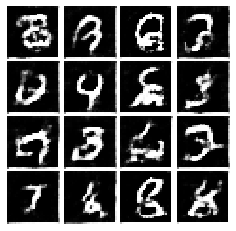


Iter: 500, D: 1.14, G:1.125


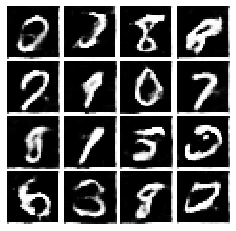


Iter: 750, D: 1.184, G:1.842


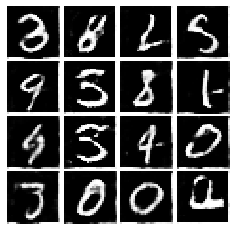


Iter: 1000, D: 1.039, G:1.117


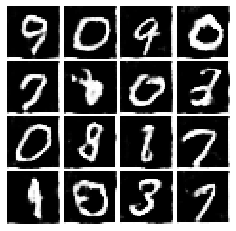


Iter: 1250, D: 1.094, G:1.71


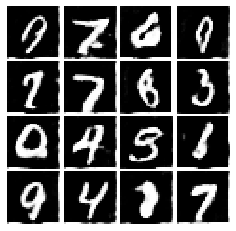


Iter: 1500, D: 0.8631, G:1.264


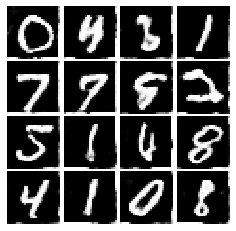


Iter: 1750, D: 0.8514, G:1.483


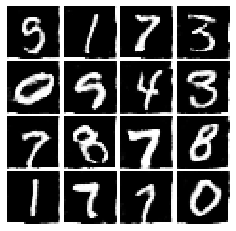

In [12]:
D_DC = build_glyph_gan_discriminator(LOADER_BATCH_SIZE, 1).type(dtype) 
D_DC.apply(initialize_weights)
G_DC = build_generator(LOADER_BATCH_SIZE, NOISE_DIM).type(dtype)
G_DC.apply(initialize_weights)

D_DC_solver = get_optimizer(D_DC)
G_DC_solver = get_optimizer(G_DC)

run_a_gan(D_DC, G_DC, D_DC_solver, G_DC_solver, discriminator_loss, generator_loss, num_epochs=5)

## Not so shabby!

1) I had a few missteps here with adding a BN layer in, which caused funny results.
2) I had dropout in there, but removed it.

In [13]:
def build_glyph_gan_generator(batch_size, noise_dim):
    """
    PyTorch model implementing the GlyphGAN generator.
    """ 
    return nn.Sequential(
        nn.Linear(noise_dim, 1024),
        nn.ReLU(),
        nn.BatchNorm1d(1024),
        
        nn.Linear(1024, 4 * 4 * 256),
        nn.ReLU(),
        nn.BatchNorm1d(4 * 4 * 256),
        
        Unflatten(batch_size, 256, 4, 4),
        
        # torch.nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride=1, padding=0, output_padding=0, groups=1, bias=True, dilation=1, padding_mode='zeros')
        # Fractionally Strided Conv 1 (4x4 -> 8x8)
        nn.ConvTranspose2d(256, 128, 4, 2, 1),
        nn.ReLU(),
        nn.BatchNorm2d(128),
        
        # Fractionally Strided Conv 2 (8x8 -> 16x16)
        nn.ConvTranspose2d(128, 64, 4, 2, 1),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        
        # Fractionally Strided Conv 2 (16x16 -> 32x32)
        nn.ConvTranspose2d(64, 32, 4, 2, 1),
        
        # Don't add an a non-linearity here because we overshot (16->32)
        # (32x32 -> 28x28)
        nn.Conv2d(32, 1, 5, stride=1),
        
        nn.Tanh(),
        nn.Flatten(1)
    )

test_g_gan = build_glyph_gan_generator(LOADER_BATCH_SIZE, NOISE_DIM).type(dtype)
test_g_gan.apply(initialize_weights)

fake_seed = torch.randn(LOADER_BATCH_SIZE, NOISE_DIM).type(dtype)
fake_images = test_g_gan.forward(fake_seed)
fake_images.size()

torch.Size([128, 784])

Iter: 0, D: 1.379, G:0.6449


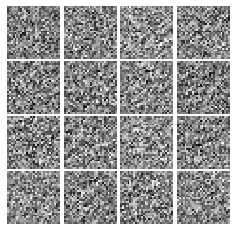

KeyboardInterrupt: 

In [14]:
D_DC = build_glyph_gan_discriminator(LOADER_BATCH_SIZE, 1).type(dtype) 
D_DC.apply(initialize_weights)
G_DC = build_glyph_gan_generator(LOADER_BATCH_SIZE, NOISE_DIM).type(dtype)
G_DC.apply(initialize_weights)

D_DC_solver = get_optimizer(D_DC)
G_DC_solver = get_optimizer(G_DC)

run_a_gan(D_DC, G_DC, D_DC_solver, G_DC_solver, discriminator_loss, generator_loss, num_epochs=5)

## Changing the input vector

GlyphGAN changes the input `z`. Rather than using a single, randomly generated 1024 array (as we do above), it uses:

`Zc`, a one-hot (aka a 0 matrix with 1s along the diagonal, representing each class) vector, and a style vector `Zs` (100Dim).

In [52]:
def calculate_gradient_penalty(D, real_data, generated_data, batch_size, gradient_penalty_weight, losses):
    # Calculate interpolation
    alpha = torch.rand(batch_size, 1, 1, 1).expand_as(real_data).type(dtype)
    
    interpolated = (alpha * real_data.data + (1 - alpha) * generated_data.data).type(dtype)
    interpolated.requires_grad = True
    
    # Calculate probability of interpolated examples
    probability_interpolated = D(interpolated)
    
    #TODO: Clean up?
    gradients = torch_grad(outputs=probability_interpolated,
                           inputs=interpolated,
                           grad_outputs=torch.ones(probability_interpolated.size()).type(dtype),
                           create_graph=True,
                           retain_graph=True)[0]
    
    # Gradients have shape (batch_size, num_channels, img_width, img_height),
    # so flatten to easily take norm per example in batch
    gradients = gradients.view(batch_size, -1)
    losses['gradient_norm'].append(gradients.norm(2, dim=1).mean().data)
    
    # Derivatives of the gradient close to 0 can cause problems because of
    # the square root, so manually calculate norm and add epsilon
    gradients_norm = torch.sqrt(torch.sum(gradients ** 2, dim=1) + 1e-12)

    # Return gradient penalty
    return gradient_penalty_weight * ((gradients_norm - 1) ** 2).mean()

def generate_data(G, batch_size, noise_size):
    seed = sample_noise(batch_size, noise_size).type(dtype)
    return G(seed).detach().view(batch_size, 1, 28, 28)
    
    
def train_critic(D, G, D_solver, batch_size, noise_size, data, gradient_penalty_weight, losses):
    """
    Trains the critic (discriminator.) This is a single iteration step.
    """
    # Prepare our data
    generated_data = generate_data(G, batch_size, noise_size)

    # Forward Pass - Calculate probabilities on real and generated data
    d_real = D(data)
    d_generated = D(generated_data)
    
    # Calculate gradient penalty
    gradient_penalty = calculate_gradient_penalty(D, data, generated_data, batch_size, gradient_penalty_weight, losses)
    losses['GP'].append(gradient_penalty.data)
    
    #TODO: Does this go here or at the start?
    D_solver.zero_grad()
    
    d_loss = d_generated.mean() - d_real.mean() + gradient_penalty
    d_loss.backward()
    losses['D'].append(d_loss.data)
    
    D_solver.step()
    
def train_generator(D, G, G_solver, batch_size, noise_size, data, losses):
    """
    Trains the generator. This is a single iteration step.
    """
    G_solver.zero_grad()
    
    # Prepare our data
    generated_data = generate_data(G, batch_size, noise_size)
    
    # Forward Pass
    d_generated = D(generated_data)
    
    loss = -d_generated.mean()
    loss.backward()
    losses['G'].append(loss.data)
    
    G_solver.step()
    

def train_epoch(D, G, D_solver, G_solver, batch_size, noise_size, data_loader, gradient_penalty_weight, losses):
    steps = 0
    critic_iterations = 5
    for data, labels in data_loader:
        steps += 1
        
        train_critic(D, G, D_solver, batch_size, noise_size, data.type(dtype), gradient_penalty_weight, losses)
        
        if steps % critic_iterations == 0:
            train_generator(D, G, G_solver, batch_size, noise_size, data, losses)
        
    
def run_a_glyph_gan(D, G, D_solver, G_solver, discriminator_loss, generator_loss, show_every=250, batch_size=128, noise_size=96, epoch_count=10):
    """
    Implementation of WGAN-GP
    """
    
    # Use a fixed seed to monitor improvement over time!
    # This is only used for debugging/visual purposes
    fixed_seed = sample_noise(batch_size, noise_size).type(dtype)
    training_progress_images = []

    # Visualize what it looks like at the start!
    image_grid = make_grid(G(fixed_seed).cpu().data)
    image_grid = np.transpose(image_grid.numpy(), (1, 2, 0))
    training_progress_images.append(image_grid)
    
    losses = {'G': [], 'D': [], 'GP': [], 'gradient_norm': []}
    start_time = time.time()
    for epoch in range(epoch_count):
        epoch_start_time = time.time()
        print('Epoch #{} Starting'.format(epoch + 1))
        train_epoch(D, G, D_solver, G_solver, batch_size, noise_size, loader_train, 10, losses)
        print('Epoch #{} total time: #{:.2}'.format(epoch + 1, (time.time() - epoch_start_time)))
        
        print("D: {}".format(losses['D'][-1]))
        print("GP: {}".format(losses['GP'][-1]))
        print("Gradient norm: {}".format(losses['gradient_norm'][-1]))
        print("G: {}".format(losses['G'][-1]))
        
        # Sample our generator using the fixed seed -- we can watch the improvement over time!
        image_grid = make_grid(G(fixed_seed).cpu().data)
        image_grid = np.transpose(image_grid.numpy(), (1, 2, 0))
        training_progress_images.append(image_grid)
    
    print('Total training time: #{:.2}'.format((time.time() - start_time)))
    
    imageio.mimsave('./training_{}_epochs.gif'.format(epoch_count), training_progress_images)

In [61]:
D_DC = build_glyph_gan_discriminator(LOADER_BATCH_SIZE, 1).type(dtype) 
D_DC.apply(initialize_weights)
G_DC = build_glyph_gan_generator(LOADER_BATCH_SIZE, NOISE_DIM).type(dtype)
G_DC.apply(initialize_weights)

D_DC_solver = get_optimizer(D_DC)
G_DC_solver = get_optimizer(G_DC)

run_a_glyph_gan(D_DC, G_DC, D_DC_solver, G_DC_solver, discriminator_loss, generator_loss, epoch_count=5)

Epoch #1 Starting
Epoch #1 total time: #4.3e+02
D: -11.864805221557617
GP: 2.7694642543792725
Gradient norm: 1.512008547782898
G: -2.7071216106414795
Epoch #2 Starting


KeyboardInterrupt: 